In [1]:
import numpy as np
import warnings

warnings. filterwarnings('ignore') 

## Customer Sentiment Analysis

### Case study on Amazon Fine Food Reviews dataset from Kaggle

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Reviews.csv') #file is from Kaggle related to Amazon Fine Food Reviews dataset
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
df.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

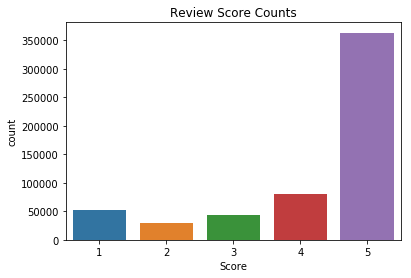

In [7]:
sns.countplot(
  x='Score',
  data=df)

plt.xlabel("Score")
plt.title("Review Score Counts");

### Reviews with a score greater than 3 are classified as Positive and others as Negative

In [8]:
df["sentiment"] = df["Score"].apply(lambda x: 'Positive' if x > 3 else 'Negative')

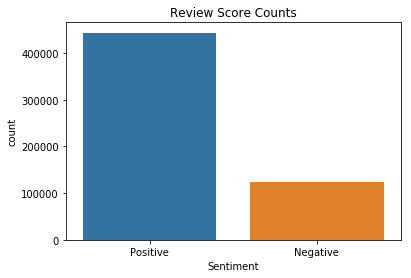

In [9]:
sns.countplot(
  x='sentiment',
  data=df
)

plt.xlabel("Sentiment")
plt.title("Review Score Counts");

In [10]:
positive_reviews = df[df.sentiment == "Positive"]
negative_reviews = df[df.sentiment == "Negative"]
print('Positive Reviews: ', positive_reviews.shape, '\tNegative Reviews: ', negative_reviews.shape)

Positive Reviews:  (443777, 11) 	Negative Reviews:  (124677, 11)


In [11]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

positive_reviews_text = " ".join(positive_reviews.Text.to_numpy().tolist())
negative_reviews_text = " ".join(negative_reviews.Text.to_numpy().tolist())

positive_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(positive_reviews_text)
negative_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(negative_reviews_text)

### Stopwords are the words that do not contribute much to classify the review as positive and negative, infact they are not keywords in the sentence. Hence removing stopwords from each review.

In [12]:
import nltk
from nltk.corpus import stopwords

stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in df.Text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)

### Displaying most frequently used words in the reviews. Higher the font, higher is the frequency of the word.

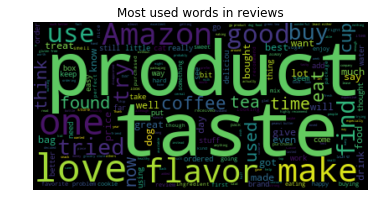

In [13]:
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.title("Most used words in reviews")
plt.savefig('wordcloud11.png')
plt.show()

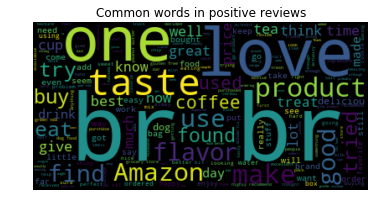

In [14]:
plt.imshow(positive_reviews_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common words in positive reviews")
plt.show()

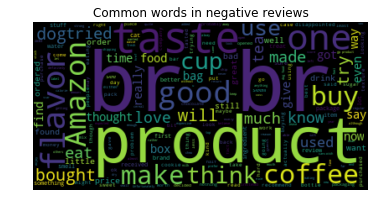

In [15]:
plt.imshow(negative_reviews_cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common words in negative reviews")
plt.show()

In [16]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  df.sentiment.to_numpy().reshape(-1, 1)
)

In [17]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
df['Text'] = df['Text'].apply(remove_punctuation)

In [18]:
dfNew = df[['Text','sentiment']]
dfNew.head()

,Text,sentiment
0,I have bought several of the Vitality canned d...,Positive
1,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,This is a confection that has been around a fe...,Positive
3,If you are looking for the secret ingredient i...,Negative
4,Great taffy at a great price There was a wide...,Positive


### Tokenizing words in the text

In [19]:
dfNew['Text'] = dfNew['Text'].apply(nltk.word_tokenize)

### The idea of stemming is to normalize our text for all variations of words carry the same meaning, regardless of the tense. One of the most popular stemming algorithms is the Porter Stemmer:

In [20]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
 
dfNew['Text'] = dfNew['Text'].apply(lambda x: [stemmer.stem(y) for y in x])

### Transform the data into occurrences, which will be the features fed into the model.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# This converts the list of words into space-separated strings
dfNew['Text'] = dfNew['Text'].apply(lambda x: ' '.join(x))

count_vect = CountVectorizer()
counts = count_vect.fit_transform(dfNew['Text'])

### Term Frequency Inverse Document Frequency, more known as tf-idf

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts)

counts = transformer.transform(counts)

### Training the model: For text classification problems, the Multinomial Naive Bayes Classifier is well-suited. 

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts,  dfNew['sentiment'], test_size=0.1, random_state=69)

In [24]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(X_train, y_train)

### Evaluating the Model

In [25]:
y_pred = model.predict(X_test)

print(np.mean(y_pred == y_test))

0.8097843295922317


In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('The confusion matrix for positive/negative classification: ')
print(confusion_matrix(y_test, y_pred))     

The confusion matrix for positive/negative classification: 
[[ 1823 10660]
 [  153 44210]]


In [27]:
print('Accuracy of classification: ' , accuracy_score(y_test, y_pred))

Accuracy of classification:  0.8097843295922317


Though the accuracy is high, the confusion matrix has a lot of misclassified reviews due to the imbalance in the dataset. Hence, this model has to be trained further to improve the numbers in confusion matrix.